- correlation or association is not causation
- observed relationships between two variables do not necessarily mean that one causes the other
- correlation refers to a linear relationship between two variables whereas association refers to any relationship between two (or more) variables
- Causation, on the other hand, means that one variable (often called the predictor variable or independent variable) causes the other (often called the outcome variable or dependent variable)

# Imports

In [2]:
import os
import numpy as np
import pandas as pd
import bnlearn
from statsmodels.stats.outliers_influence import variance_inflation_factor

from scipy.stats import hypergeom

# Read data

In [9]:
# Get root directory
root_dir = os.path.dirname(os.path.abspath(''))
# read data
df = pd.read_csv(
    os.path.join(root_dir, 'data', 'filtered_data.csv')
    )

# BART (Bayesian Additive Regression Tree):

https://stats.stackexchange.com/questions/446416/how-does-bart-bayesian-additive-regression-tree-help-with-causal-inference#:~:text=BART%20has%20a%20few%20advantages,intervals%20can%20be%20directly%20computed.

- BART has a few advantages for causal inference that distinguish it from other methods.
- tuning parameters correspond to Bayesian priors, each predicted value has a posterior distribution, from which credible intervals can be directly computed
- it is extremely flexible and is able to account for nonlinearities and interactions without overfitting due to the Bayesian priors
- it's possible to incorporate substantive information into the priors, for example, on which variables to perform a split or for which variables the treatment effect should vary


https://faculty.mccombs.utexas.edu/carlos.carvalho/BCFTalk_March2019.pdf



https://www.youtube.com/watch?v=9d5-3_7u5a4

Regression Tree (non param approach):
- Algorithmic partition of data into non-overlapping subsets
- Goal is to minimize the variance in the response variable within subsets
- Resulting regression fit is the mean of each subset

# BNM (Bayesian Network Model):
https://towardsdatascience.com/a-step-by-step-guide-in-detecting-causal-relationships-using-bayesian-structure-learning-in-python-c20c6b31cee5

In [3]:
# Load titanic dataset
df = bnlearn.import_example(data='titanic')

print(df[['Survived','Sex']])

[bnlearn] >Downloading example [titanic_train] dataset..
[bnlearn] >Import dataset..
     Survived     Sex
0           0    male
1           1  female
2           1  female
3           1  female
4           0    male
..        ...     ...
886         0    male
887         1  female
888         0  female
889         1    male
890         0    male

[891 rows x 2 columns]


In [4]:
# Total number of samples
N=df.shape[0]
# Number of success in the population
K=sum(df['Survived']==1)
# Sample size/number of draws
n=sum(df['Sex']=='female')
# Overlap between female and survived
x=sum((df['Sex']=='female') & (df['Survived']==1))

print(x-1, N, n, K)
# 232 891 314 342

# Compute
P = hypergeom.sf(x, N, n, K)
P = hypergeom.sf(232, 891, 314, 342)

print(P)

232 891 314 342
3.5925132664694183e-60


Null hypothesis: There is no relation between survived and female.

We can reject the null hypothesis under alpha=0.05 and therefore, we can speak about a statistically significant association between survived and female. Importantly, association by itself does not imply causation. We need to distinguish between marginal associations and conditional associations. The latter is the key building block of causal inference.

If two random variables X and Y are statistically dependent (X/Y), then either:
- (a) X causes Y
- (b) Y causes X
- (c) there exists a third variable Z that causes both X and Y.

Further, X and Y become independent given Z, i.e., X⊥Y∣Z.
This definition is incorporated in Bayesian graphical models (Bayesian Networks)

![conditional_dependencies.png](attachment:conditional_dependencies.png)

The conceptual idea to determine the direction of causality, thus which node influences which node, is by holding a node constant and then observe the effect.

Bayesian network is a happy marriage between probability and graph theory. It should be noted that a Bayesian network is a Directed Acyclic Graph (DAG) and DAGs are causal. This means that the edges in the graph are directed and there is no (feedback) loop (acyclic).

With structure learning, we want to determine the structure of the graph that best captures the causal dependencies between the variables in the data set. **What is the DAG that best fits the data?**

an exhaustive search is practically infeasible with a large number of nodes, and therefore, various greedy strategies have been proposed to browse DAG space


With optimization-based search approaches, it is possible to browse a larger DAG space. Such approaches require a scoring function and a search strategy. A common scoring function is the posterior probability of the structure given the training data, like the BIC or the BDeu.

There are two broad approaches to search throughout the DAG space and find the best fitting graph for the data.
- _Score-based structure learning_: The **search algorithm** to optimize throughout the search space of all possible DAGs; such as ExhaustiveSearch, Hillclimbsearch, Chow-Liu. The **scoring function** indicates how well the Bayesian network fits the data. Commonly used scoring functions are Bayesian Dirichlet scores such as BDeu or K2 and the Bayesian Information Criterion (BIC, also called MDL).
- _Constraint-based structure learning_:

Note that a local search strategy makes incremental changes aimed at improving the score of the structure. A global search algorithm like Markov chain Monte Carlo can avoid getting trapped in local minima.

## Splinker example

### Structure Learning

In [5]:
import bnlearn as bn
# Load sprinkler dataset
df = bn.import_example('sprinkler')
# Print to screen for illustration
print(df)

[bnlearn] >Downloading example [sprinkler] dataset..
[bnlearn] >Import dataset..
     Cloudy  Sprinkler  Rain  Wet_Grass
0         0          0     0          0
1         1          0     1          1
2         0          1     0          1
3         1          1     1          1
4         1          1     1          1
..      ...        ...   ...        ...
995       1          0     1          1
996       1          0     1          1
997       1          0     1          1
998       0          0     0          0
999       0          1     1          1

[1000 rows x 4 columns]


In [16]:
# Learn the DAG in data using Bayesian structure learning:
DAG = bn.structure_learning.fit(df)

[bnlearn] >Computing best DAG using [hc]
[bnlearn] >Set scoring type at [bic]
[bnlearn] >Compute structure scores ['k2', 'bds', 'bic', 'bdeu'] for model comparison (higher is better).


In [17]:
# print adjacency matrix
print(DAG['adjmat'])

target     Cloudy  Sprinkler   Rain  Wet_Grass
source                                        
Cloudy      False      False   True      False
Sprinkler    True      False  False       True
Rain        False      False  False       True
Wet_Grass   False      False  False      False


[bnlearn] >Set node properties.
[bnlearn] >Set edge properties.
[bnlearn] >Plot based on Bayesian model


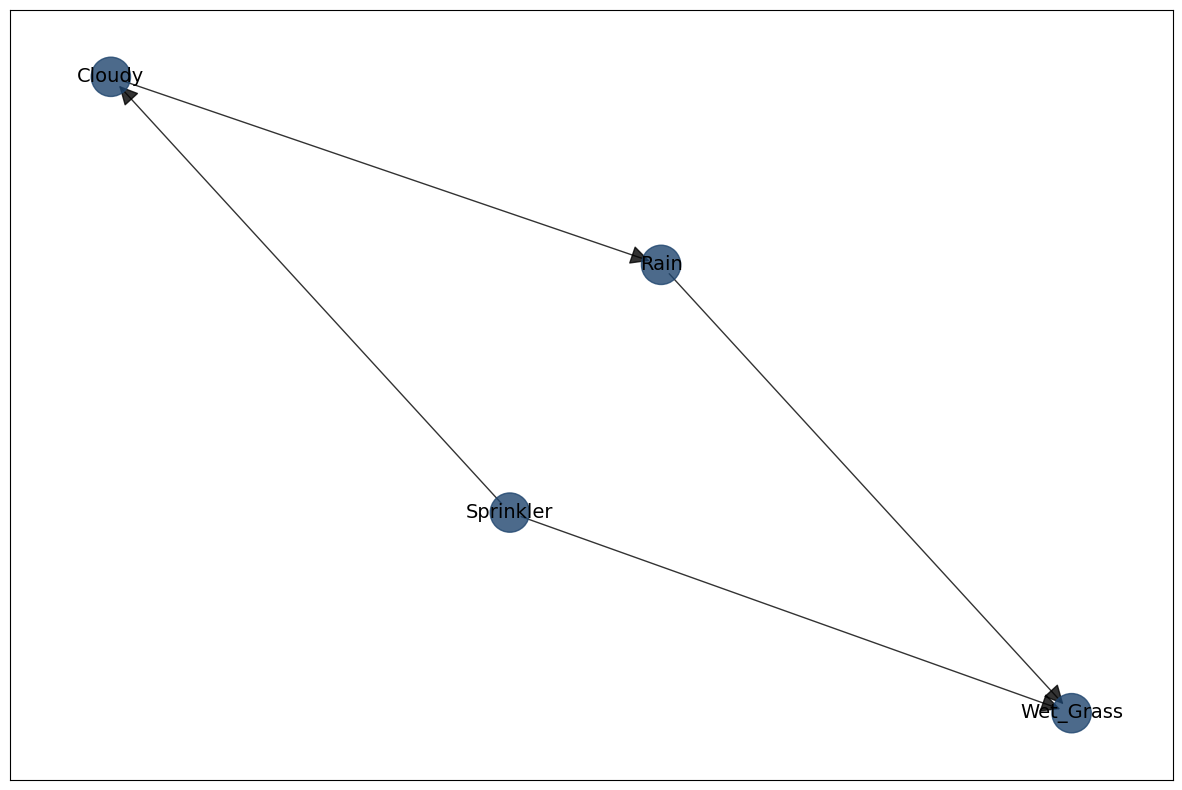

In [18]:
# Plot
G = bn.plot(DAG)

In [ ]:
# 'hc' or 'hillclimbsearch'
model_hc_bic  = bn.structure_learning.fit(df, methodtype='hc', scoretype='bic')
model_hc_k2   = bn.structure_learning.fit(df, methodtype='hc', scoretype='k2')
model_hc_bdeu = bn.structure_learning.fit(df, methodtype='hc', scoretype='bdeu')

# 'ex' or 'exhaustivesearch'
model_ex_bic  = bn.structure_learning.fit(df, methodtype='ex', scoretype='bic')
model_ex_k2   = bn.structure_learning.fit(df, methodtype='ex', scoretype='k2')
model_ex_bdeu = bn.structure_learning.fit(df, methodtype='ex', scoretype='bdeu')

# 'cs' or 'constraintsearch'
model_cs_k2   = bn.structure_learning.fit(df, methodtype='cs', scoretype='k2')
model_cs_bdeu = bn.structure_learning.fit(df, methodtype='cs', scoretype='bdeu')
model_cs_bic  = bn.structure_learning.fit(df, methodtype='cs', scoretype='bic')

# 'cl' or 'chow-liu' (requires setting root_node parameter)
model_cl      = bn.structure_learning.fit(df, methodtype='cl', root_node='Wet_Grass')


### Parameter Learning

In [20]:
# Define the causal dependencies based on your expert/domain knowledge.
# Left is the source, and right is the target node.
edges = [('Cloudy', 'Sprinkler'),
         ('Cloudy', 'Rain'),
         ('Sprinkler', 'Wet_Grass'),
         ('Rain', 'Wet_Grass')]

In [21]:
# Create the DAG
DAG = bn.make_DAG(edges)

[bnlearn] >bayes DAG created.


[bnlearn] >Set node properties.
[bnlearn] >Set edge properties.
[bnlearn] >Plot based on Bayesian model


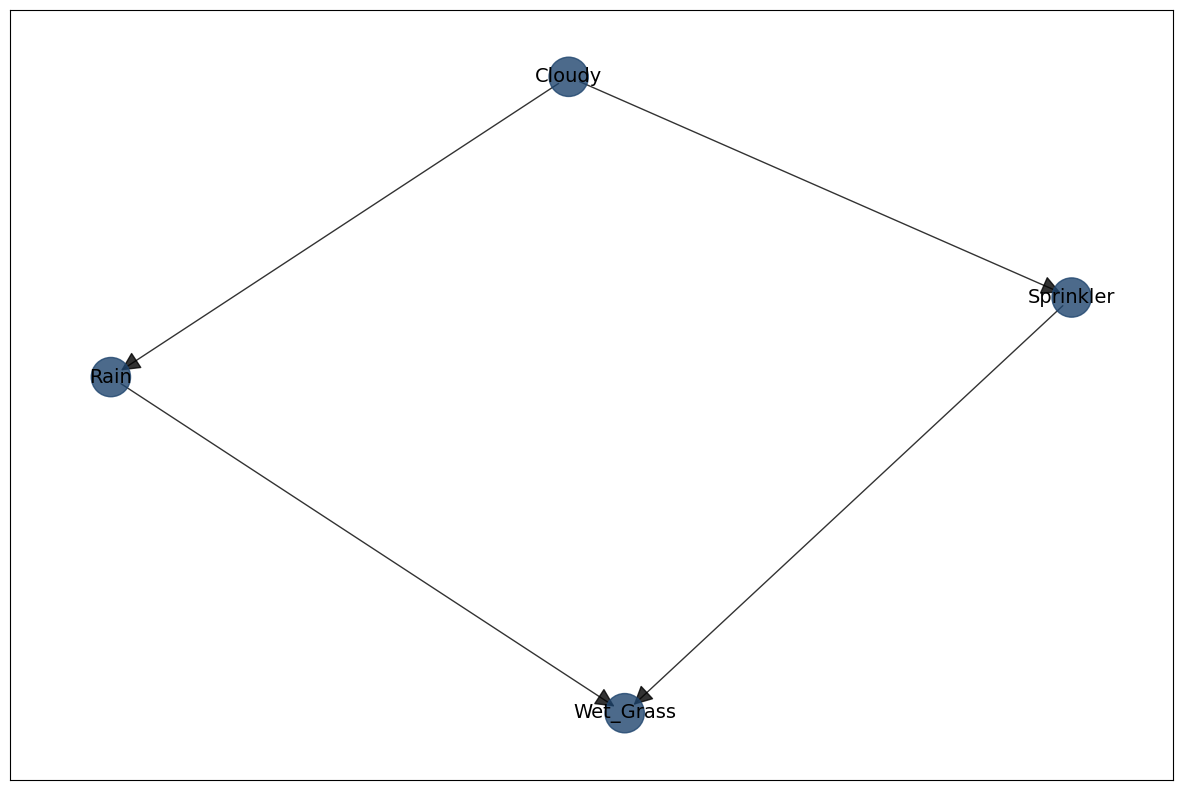

{'fig': <Figure size 1500x1000 with 1 Axes>,
 'ax': <Figure size 1500x1000 with 1 Axes>,
 'pos': {'Cloudy': array([-0.05234133,  0.60921941]),
  'Sprinkler': array([0.98874247, 0.14450172]),
  'Rain': array([-1.        , -0.02304454]),
  'Wet_Grass': array([ 0.06359885, -0.73067659])},
 'G': <networkx.classes.digraph.DiGraph at 0x186c7d2d0>,
 'node_properties': {'Cloudy': {'node_color': '#1f456e', 'node_size': 800},
  'Sprinkler': {'node_color': '#1f456e', 'node_size': 800},
  'Rain': {'node_color': '#1f456e', 'node_size': 800},
  'Wet_Grass': {'node_color': '#1f456e', 'node_size': 800}},
 'edge_properties': {('Cloudy', 'Sprinkler'): {'color': '#000000',
   'weight': 1},
  ('Cloudy', 'Rain'): {'color': '#000000', 'weight': 1},
  ('Sprinkler', 'Wet_Grass'): {'color': '#000000', 'weight': 1},
  ('Rain', 'Wet_Grass'): {'color': '#000000', 'weight': 1}}}

In [22]:
# Plot the DAG. This is identical as shown in Figure 3
bn.plot(DAG)

In [24]:
# Print the Conditional probability Tables
bn.print_CPD(DAG)

# This is correct, we did not learn any CPTs yet! We only defined the graph without defining any probabilities.

[bnlearn] >No CPDs to print. Hint: Add CPDs as following: <bn.make_DAG(DAG, CPD=[cpd_A, cpd_B, etc])> and use bnlearn.plot(DAG) to make a plot.


{}

In [25]:
# Parameter learning on the user-defined DAG and input data using maximumlikelihood
model_mle = bn.parameter_learning.fit(DAG, df, methodtype='maximumlikelihood')

[bnlearn] >Parameter learning> Computing parameters using [maximumlikelihood]
[bnlearn] >CPD of Cloudy:
+-----------+-------+
| Cloudy(0) | 0.488 |
+-----------+-------+
| Cloudy(1) | 0.512 |
+-----------+-------+
[bnlearn] >CPD of Sprinkler:
+--------------+--------------------+------------+
| Cloudy       | Cloudy(0)          | Cloudy(1)  |
+--------------+--------------------+------------+
| Sprinkler(0) | 0.4610655737704918 | 0.91015625 |
+--------------+--------------------+------------+
| Sprinkler(1) | 0.5389344262295082 | 0.08984375 |
+--------------+--------------------+------------+
[bnlearn] >CPD of Rain:
+---------+---------------------+-------------+
| Cloudy  | Cloudy(0)           | Cloudy(1)   |
+---------+---------------------+-------------+
| Rain(0) | 0.8073770491803278  | 0.177734375 |
+---------+---------------------+-------------+
| Rain(1) | 0.19262295081967212 | 0.822265625 |
+---------+---------------------+-------------+
[bnlearn] >CPD of Wet_Grass:
+----------

In [27]:
# Print the learned CPDs
bn.print_CPD(model_mle)

[bnlearn] >Data is stored in [query.df]
+----+----------+-------+
|    |   Cloudy |     p |
+====+==========+=======+
|  0 |        0 | 0.488 |
+----+----------+-------+
|  1 |        1 | 0.512 |
+----+----------+-------+
CPD of Cloudy:
+-----------+-------+
| Cloudy(0) | 0.488 |
+-----------+-------+
| Cloudy(1) | 0.512 |
+-----------+-------+
[bnlearn] >Data is stored in [query.df]
+----+-------------+----------+-----------+
|    |   Sprinkler |   Cloudy |         p |
+====+=============+==========+===========+
|  0 |           0 |        0 | 0.461066  |
+----+-------------+----------+-----------+
|  1 |           0 |        1 | 0.910156  |
+----+-------------+----------+-----------+
|  2 |           1 |        0 | 0.538934  |
+----+-------------+----------+-----------+
|  3 |           1 |        1 | 0.0898438 |
+----+-------------+----------+-----------+
CPD of Sprinkler:
+--------------+--------------------+------------+
| Cloudy       | Cloudy(0)          | Cloudy(1)  |
+--------

{'Cloudy':    Cloudy      p
 0       0  0.488
 1       1  0.512,
 'Sprinkler':    Sprinkler  Cloudy         p
 0          0       0  0.461066
 1          0       1  0.910156
 2          1       0  0.538934
 3          1       1  0.089844,
 'Rain':    Rain  Cloudy         p
 0     0       0  0.807377
 1     0       1  0.177734
 2     1       0  0.192623
 3     1       1  0.822266,
 'Wet_Grass':    Wet_Grass  Rain  Sprinkler         p
 0          0     0          0  1.000000
 1          0     0          1  0.156250
 2          0     1          0  0.113953
 3          0     1          1  0.023529
 4          1     0          0  0.000000
 5          1     0          1  0.843750
 6          1     1          0  0.886047
 7          1     1          1  0.976471}

In [29]:
# Parameter learning on the user-defined DAG and input data using Bayes
model_bayes = bn.parameter_learning.fit(DAG, df, methodtype='bayes')

# Print the learned CPDs
bn.print_CPD(model_bayes)

[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >CPD of Cloudy:
+-----------+-------+
| Cloudy(0) | 0.494 |
+-----------+-------+
| Cloudy(1) | 0.506 |
+-----------+-------+
[bnlearn] >CPD of Sprinkler:
+--------------+--------------------+--------------------+
| Cloudy       | Cloudy(0)          | Cloudy(1)          |
+--------------+--------------------+--------------------+
| Sprinkler(0) | 0.4807692307692308 | 0.7075098814229249 |
+--------------+--------------------+--------------------+
| Sprinkler(1) | 0.5192307692307693 | 0.2924901185770751 |
+--------------+--------------------+--------------------+
[bnlearn] >CPD of Rain:
+---------+--------------------+---------------------+
| Cloudy  | Cloudy(0)          | Cloudy(1)           |
+---------+--------------------+---------------------+
| Rain(0) | 0.6518218623481782 | 0.33695652173913043 |
+---------+--------------------+---------------------+
| Rain(1) | 0.3481781376518219 | 0.6630434782608695  |
+-

{'Cloudy':    Cloudy      p
 0       0  0.494
 1       1  0.506,
 'Sprinkler':    Sprinkler  Cloudy         p
 0          0       0  0.480769
 1          0       1  0.707510
 2          1       0  0.519231
 3          1       1  0.292490,
 'Rain':    Rain  Cloudy         p
 0     0       0  0.651822
 1     0       1  0.336957
 2     1       0  0.348178
 3     1       1  0.663043,
 'Wet_Grass':    Wet_Grass  Rain  Sprinkler         p
 0          0     0          0  0.755382
 1          0     0          1  0.337553
 2          0     1          0  0.255882
 3          0     1          1  0.379104
 4          1     0          0  0.244618
 5          1     0          1  0.662447
 6          1     1          0  0.744118
 7          1     1          1  0.620896}

### Inferences

In [30]:
# Parameter learning on the user-defined DAG and input data using Bayes to estimate the CPTs
model = bn.parameter_learning.fit(DAG, df, methodtype='bayes')
bn.print_CPD(model)

[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >CPD of Cloudy:
+-----------+-------+
| Cloudy(0) | 0.494 |
+-----------+-------+
| Cloudy(1) | 0.506 |
+-----------+-------+
[bnlearn] >CPD of Sprinkler:
+--------------+--------------------+--------------------+
| Cloudy       | Cloudy(0)          | Cloudy(1)          |
+--------------+--------------------+--------------------+
| Sprinkler(0) | 0.4807692307692308 | 0.7075098814229249 |
+--------------+--------------------+--------------------+
| Sprinkler(1) | 0.5192307692307693 | 0.2924901185770751 |
+--------------+--------------------+--------------------+
[bnlearn] >CPD of Rain:
+---------+--------------------+---------------------+
| Cloudy  | Cloudy(0)          | Cloudy(1)           |
+---------+--------------------+---------------------+
| Rain(0) | 0.6518218623481782 | 0.33695652173913043 |
+---------+--------------------+---------------------+
| Rain(1) | 0.3481781376518219 | 0.6630434782608695  |
+-

{'Cloudy':    Cloudy      p
 0       0  0.494
 1       1  0.506,
 'Sprinkler':    Sprinkler  Cloudy         p
 0          0       0  0.480769
 1          0       1  0.707510
 2          1       0  0.519231
 3          1       1  0.292490,
 'Rain':    Rain  Cloudy         p
 0     0       0  0.651822
 1     0       1  0.336957
 2     1       0  0.348178
 3     1       1  0.663043,
 'Wet_Grass':    Wet_Grass  Rain  Sprinkler         p
 0          0     0          0  0.755382
 1          0     0          1  0.337553
 2          0     1          0  0.255882
 3          0     1          1  0.379104
 4          1     0          0  0.244618
 5          1     0          1  0.662447
 6          1     1          0  0.744118
 7          1     1          1  0.620896}

In [31]:
q1 = bn.inference.fit(model, variables=['Wet_Grass'], evidence={'Sprinkler':0})
print(q1.df)

[bnlearn] >Variable Elimination..
[bnlearn] >Data is stored in [query.df]
+----+-------------+----------+
|    |   Wet_Grass |        p |
+====+=============+==========+
|  0 |           0 | 0.486917 |
+----+-------------+----------+
|  1 |           1 | 0.513083 |
+----+-------------+----------+
   Wet_Grass         p
0          0  0.486917
1          1  0.513083


In [32]:
q2 = bn.inference.fit(model, variables=['Rain'], evidence={'Sprinkler':0, 'Cloudy':1})
print(q2.df)

[bnlearn] >Variable Elimination..
[bnlearn] >Data is stored in [query.df]
+----+--------+----------+
|    |   Rain |        p |
+====+========+==========+
|  0 |      0 | 0.336957 |
+----+--------+----------+
|  1 |      1 | 0.663043 |
+----+--------+----------+
   Rain         p
0     0  0.336957
1     1  0.663043


In [33]:
# Inferences with two or more variables can also be made such as:
q3 = bn.inference.fit(model, variables=['Wet_Grass','Rain'], evidence={'Sprinkler':1})
print(q3.df)

[bnlearn] >Variable Elimination..
[bnlearn] >Data is stored in [query.df]
+----+-------------+--------+----------+
|    |   Wet_Grass |   Rain |        p |
+====+=============+========+==========+
|  0 |           0 |      0 | 0.181137 |
+----+-------------+--------+----------+
|  1 |           0 |      1 | 0.17567  |
+----+-------------+--------+----------+
|  2 |           1 |      0 | 0.355481 |
+----+-------------+--------+----------+
|  3 |           1 |      1 | 0.287712 |
+----+-------------+--------+----------+
   Wet_Grass  Rain         p
0          0     0  0.181137
1          0     1  0.175670
2          1     0  0.355481
3          1     1  0.287712


How probable is it to have wet grass given the sprinkler is off?

P(Wet_grass=1 | Sprinkler=0) = 0.51

How probable is it have a rainy day given sprinkler is off and it is cloudy?

P(Rain=1 | Sprinkler=0, Cloudy=1) = 0.663

## Application

In [79]:
# Get root directory
root_dir = os.path.dirname(os.path.abspath(''))
# read data
df_1 = pd.read_csv(
    os.path.join(root_dir, 'data', 'filtered_data.csv')
    )

In [80]:
df_1

,edad,hombre,minoria_raza,anios_educacion,discapacidad,enfermedad,meses_en_calle,anios_en_calle,contacto_familia,recibe_ayuda,consume_drogas,edad_promedio_inicio_consumo,minoria_lgbt,ln_edad,ln_edad_promedio_inicio_consumo,ln_meses_en_calle,ln_anios_en_calle
0,44.0,1,0,7.0,1,0,179.0,14.916667,0,0,0,0.000000,0,3.784190,0.000000,5.187386,2.702479
1,33.0,1,0,2.0,1,0,168.0,14.000000,0,0,0,0.000000,0,3.496508,0.000000,5.123964,2.639057
2,41.0,1,0,15.0,1,0,36.0,3.000000,0,0,0,0.000000,0,3.713572,0.000000,3.583519,1.098612
3,29.0,1,0,7.0,0,0,60.0,5.000000,0,0,0,0.000000,0,3.367296,0.000000,4.094345,1.609438
4,30.0,1,0,11.0,0,0,168.0,14.000000,0,0,0,0.000000,0,3.401197,0.000000,5.123964,2.639057
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5335,44.0,1,1,15.0,0,0,24.0,2.000000,1,1,1,19.000000,0,3.784190,2.944439,3.178054,0.693147
5336,35.0,1,0,2.0,0,0,240.0,20.000000,1,1,1,15.500000,0,3.555348,2.740840,5.480639,2.995732
5337,53.0,1,1,2.0,0,0,264.0,22.000000,1,1,0,0.000000,0,3.970292,0.000000,5.575949,3.091042
5338,57.0,0,0,7.0,1,1,114.0,9.500000,1,0,1,25.000000,0,4.043051,3.218876,4.736198,2.251292


In [81]:
df_1.columns

Index(['edad', 'hombre', 'minoria_raza', 'anios_educacion', 'discapacidad',
       'enfermedad', 'meses_en_calle', 'anios_en_calle', 'contacto_familia',
       'recibe_ayuda', 'consume_drogas', 'edad_promedio_inicio_consumo',
       'minoria_lgbt', 'ln_edad', 'ln_edad_promedio_inicio_consumo',
       'ln_meses_en_calle', 'ln_anios_en_calle'],
      dtype='object')

In [82]:
df = df_1[['anios_en_calle', 'consume_drogas', 'edad', 'contacto_familia', 'enfermedad']]
# df = df_1

In [83]:
# Learn the DAG in data using Bayesian structure learning:
DAG = bn.structure_learning.fit(df)

[bnlearn] >Computing best DAG using [hc]
[bnlearn] >Set scoring type at [bic]
[bnlearn] >Compute structure scores ['k2', 'bds', 'bic', 'bdeu'] for model comparison (higher is better).


In [84]:
# print adjacency matrix
print(DAG['adjmat'])

target            anios_en_calle  consume_drogas   edad  contacto_familia   
source                                                                      
anios_en_calle             False           False  False             False  \
consume_drogas             False           False   True             False   
edad                       False           False  False             False   
contacto_familia           False           False  False             False   
enfermedad                 False           False  False             False   

target            enfermedad  
source                        
anios_en_calle         False  
consume_drogas          True  
edad                   False  
contacto_familia       False  
enfermedad             False  


[bnlearn] >Set node properties.
[bnlearn] >Set edge properties.
[bnlearn] >Plot based on Bayesian model


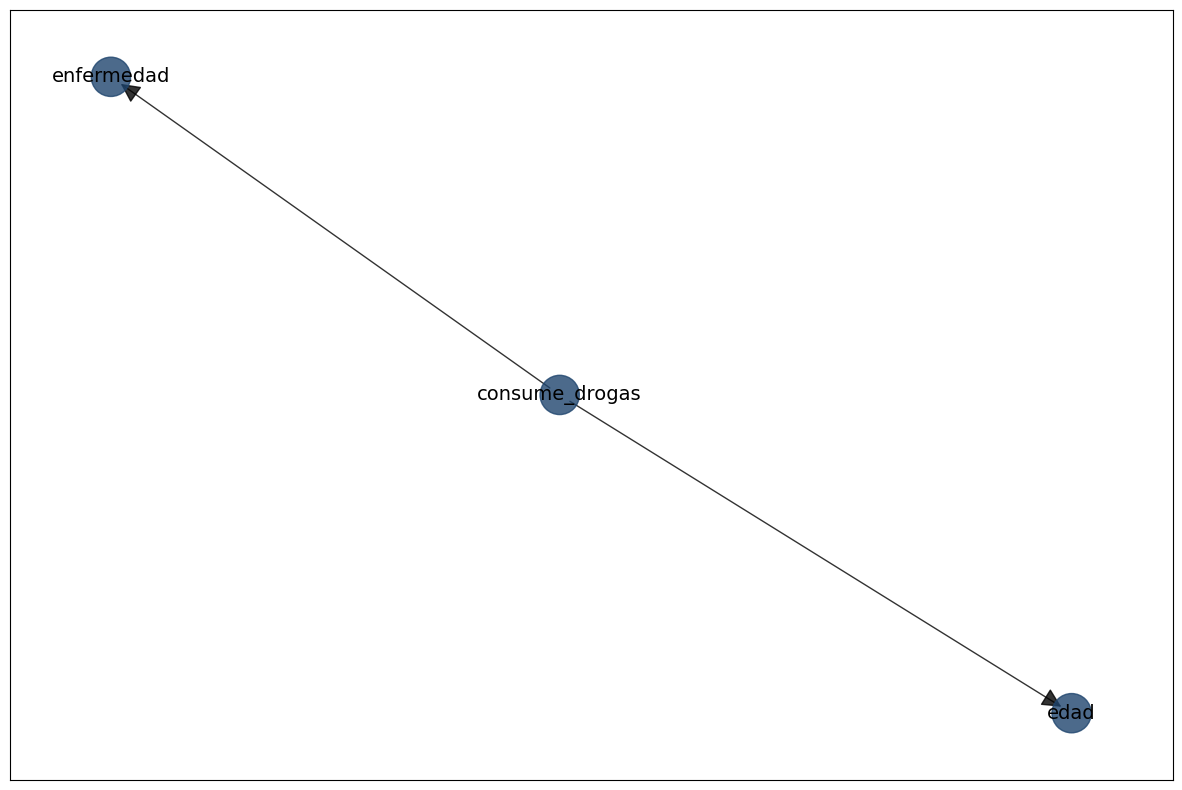

In [85]:
# Plot
G = bn.plot(DAG)